In [1]:
%%capture
# @title Install Dependencies { display-mode: "form" }

!curl -L https://raw.githubusercontent.com/facebookresearch/habitat-sim/main/examples/colab_utils/colab_install.sh | NIGHTLY=false bash -s

Download (testing) 3D scenes:

In [2]:
!python -m habitat_sim.utils.datasets_download --uids habitat_test_scenes --data-path data/

git clone --depth 1 --branch main https://huggingface.co/datasets/ai-habitat/habitat_test_scenes.git /data/reventh/habitat-lab/examples/tutorials/colabs/data/versioned_data/habitat_test_scenes
Cloning into '/data/reventh/habitat-lab/examples/tutorials/colabs/data/versioned_data/habitat_test_scenes'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 0), reused 11 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), 16.62 KiB | 2.77 MiB/s, done.
Filtering content: 100% (4/4), 105.54 MiB | 56.58 MiB/s, done.
prune: 4 local objects, 0 retained, done.                                       
prune: Deleting objects: 100% (4/4), done.                                      
Dataset (habitat_test_scenes) successfully downloaded.
Source: '/data/reventh/habitat-lab/examples/tutorials/colabs/data/versioned_data/habitat_test_scenes'
Symlink: '/data/reventh/habitat-lab/examples/tutorials/

Download point-goal navigation episodes for the test scenes:

In [3]:
!python -m habitat_sim.utils.datasets_download --uids habitat_test_pointnav_dataset --data-path data/

--2024-03-14 17:10:23--  http://dl.fbaipublicfiles.com/habitat/habitat-test-pointnav-dataset_v1.0.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.78, 13.226.210.111, 13.226.210.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 894623 (874K) [application/zip]
Saving to: ‘/data/reventh/habitat-lab/examples/tutorials/colabs/data/habitat-test-pointnav-dataset_v1.0.zip’

habitat-test-pointn 100%[===================>] 873.66K  --.-KB/s    in 0.03s   

2024-03-14 17:10:23 (32.9 MB/s) - ‘/data/reventh/habitat-lab/examples/tutorials/colabs/data/habitat-test-pointnav-dataset_v1.0.zip’ saved [894623/894623]

Dataset (habitat_test_pointnav_dataset) successfully downloaded.
Source: '/data/reventh/habitat-lab/examples/tutorials/colabs/data/versioned_data/habitat_test_pointnav_dataset_1.0'
Symlink: '/data/reventh/habitat-lab/examples/tutorials/colabs/data/datasets/poi

In [1]:
# [setup]
import os
from typing import TYPE_CHECKING, Union, cast

import matplotlib.pyplot as plt
import numpy as np

import habitat
from habitat.config.default_structured_configs import (
    CollisionsMeasurementConfig,
    FogOfWarConfig,
    TopDownMapMeasurementConfig,
)
from habitat.core.agent import Agent
from habitat.tasks.nav.nav import NavigationEpisode, NavigationGoal
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import (
    images_to_video,
    observations_to_image,
    overlay_frame,
)
from habitat_sim.utils import viz_utils as vut

# # Quiet the Habitat simulator logging
# os.environ["MAGNUM_LOG"] = "quiet"
# os.environ["HABITAT_SIM_LOG"] = "quiet"

# if TYPE_CHECKING:
#     from habitat.core.simulator import Observations
#     from habitat.sims.habitat_simulator.habitat_simulator import HabitatSim


# output_path = "examples/tutorials/habitat_lab_visualization/"
# if not os.path.exists(output_path):
#     os.makedirs(output_path)
# # [/setup]

/data/reventh/anaconda3/envs/habitat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

In [3]:
# [example_1]
def example_pointnav_draw_target_birdseye_view():
    # Define NavigationEpisode parameters
    goal_radius = 0.5
    goal = NavigationGoal(position=[10, 0.25, 10], radius=goal_radius)
    agent_position = [0, 0.25, 0]
    agent_rotation = -np.pi / 4

    # Create dummy episode for birdseye view visualization
    dummy_episode = NavigationEpisode(
        goals=[goal],
        episode_id="dummy_id",
        scene_id="dummy_scene",
        start_position=agent_position,
        start_rotation=agent_rotation,  # type: ignore[arg-type]
    )

    agent_position = np.array(agent_position)
    # Draw birdseye view
    target_image = maps.pointnav_draw_target_birdseye_view(
        agent_position,
        agent_rotation,
        np.asarray(dummy_episode.goals[0].position),
        goal_radius=dummy_episode.goals[0].radius,
        agent_radius_px=25,
    )
    plt.imshow(target_image)
    plt.title("pointnav_target_image.png")
    plt.show()


# [/example_1]

In [4]:
# [example_2]
def example_pointnav_draw_target_birdseye_view_agent_on_border():
    # Define NavigationGoal
    goal_radius = 0.5
    goal = NavigationGoal(position=[0, 0.25, 0], radius=goal_radius)
    # For defined goal create 4 NavigationEpisodes
    # with agent being placed on different borders,
    # draw birdseye view for each episode and save image to disk
    ii = 0
    for x_edge in [-1, 0, 1]:
        for y_edge in [-1, 0, 1]:
            if not np.bitwise_xor(x_edge == 0, y_edge == 0):
                continue
            ii += 1
            agent_position = [7.8 * x_edge, 0.25, 7.8 * y_edge]
            agent_rotation = np.pi / 2

            dummy_episode = NavigationEpisode(
                goals=[goal],
                episode_id="dummy_id",
                scene_id="dummy_scene",
                start_position=agent_position,
                start_rotation=agent_rotation,  # type: ignore[arg-type]
            )

            agent_position = np.array(agent_position)
            target_image = maps.pointnav_draw_target_birdseye_view(
                agent_position,
                agent_rotation,
                np.asarray(dummy_episode.goals[0].position),
                goal_radius=dummy_episode.goals[0].radius,
                agent_radius_px=25,
            )
            plt.imshow(target_image)
            plt.title("pointnav_target_image_edge_%d.png" % ii)
            plt.show()


# [/example_2]

In [5]:
# [example_3]
def example_get_topdown_map():
    # Create habitat config
    config = habitat.get_config(
        config_path="benchmark/nav/pointnav/pointnav_habitat_test.yaml"
    )
    # Create dataset
    dataset = habitat.make_dataset(
        id_dataset=config.habitat.dataset.type, config=config.habitat.dataset
    )
    # Create simulation environment
    with habitat.Env(config=config, dataset=dataset) as env:
        # Load the first episode
        env.reset()
        # Generate topdown map
        top_down_map = maps.get_topdown_map_from_sim(
            cast("HabitatSim", env.sim), map_resolution=1024
        )
        recolor_map = np.array(
            [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
        )
        # By default, `get_topdown_map_from_sim` returns image
        # containing 0 if occupied, 1 if unoccupied, and 2 if border
        # The line below recolors returned image so that
        # occupied regions are colored in [255, 255, 255],
        # unoccupied in [128, 128, 128] and border is [0, 0, 0]
        top_down_map = recolor_map[top_down_map]
        plt.imshow(top_down_map)
        plt.title("top_down_map.png")
        plt.show()


# [/example_3]

In [6]:
# [example_4]
class ShortestPathFollowerAgent(Agent):
    r"""Implementation of the :ref:`habitat.core.agent.Agent` interface that
    uses :ref`habitat.tasks.nav.shortest_path_follower.ShortestPathFollower` utility class
    for extracting the action on the shortest path to the goal.
    """

    def __init__(self, env: habitat.Env, goal_radius: float):
        self.env = env
        self.shortest_path_follower = ShortestPathFollower(
            sim=cast("HabitatSim", env.sim),
            goal_radius=goal_radius,
            return_one_hot=False,
        )

    def act(self, observations: "Observations") -> Union[int, np.ndarray]:
        return self.shortest_path_follower.get_next_action(
            cast(NavigationEpisode, self.env.current_episode).goals[0].position
        )

    def reset(self) -> None:
        pass


def example_top_down_map_measure():
    # Create habitat config
    config = habitat.get_config(
        config_path="benchmark/nav/pointnav/pointnav_habitat_test.yaml"
    )
    # Add habitat.tasks.nav.nav.TopDownMap and habitat.tasks.nav.nav.Collisions measures
    with habitat.config.read_write(config):
        config.habitat.task.measurements.update(
            {
                "top_down_map": TopDownMapMeasurementConfig(
                    map_padding=3,
                    map_resolution=1024,
                    draw_source=True,
                    draw_border=True,
                    draw_shortest_path=True,
                    draw_view_points=True,
                    draw_goal_positions=True,
                    draw_goal_aabbs=True,
                    fog_of_war=FogOfWarConfig(
                        draw=True,
                        visibility_dist=5.0,
                        fov=90,
                    ),
                ),
                "collisions": CollisionsMeasurementConfig(),
            }
        )
    # Create dataset
    dataset = habitat.make_dataset(
        id_dataset=config.habitat.dataset.type, config=config.habitat.dataset
    )
    # Create simulation environment
    with habitat.Env(config=config, dataset=dataset) as env:
        # Create ShortestPathFollowerAgent agent
        agent = ShortestPathFollowerAgent(
            env=env,
            goal_radius=config.habitat.task.measurements.success.success_distance,
        )
        # Create video of agent navigating in the first episode
        num_episodes = 1
        for _ in range(num_episodes):
            # Load the first episode and reset agent
            observations = env.reset()
            agent.reset()

            # Get metrics
            info = env.get_metrics()
            # Concatenate RGB-D observation and topdowm map into one image
            frame = observations_to_image(observations, info)

            # Remove top_down_map from metrics
            info.pop("top_down_map")
            # Overlay numeric metrics onto frame
            frame = overlay_frame(frame, info)
            # Add fame to vis_frames
            vis_frames = [frame]

            # Repeat the steps above while agent doesn't reach the goal
            while not env.episode_over:
                # Get the next best action
                action = agent.act(observations)
                if action is None:
                    break

                # Step in the environment
                observations = env.step(action)
                info = env.get_metrics()
                frame = observations_to_image(observations, info)

                info.pop("top_down_map")
                frame = overlay_frame(frame, info)
                vis_frames.append(frame)

            current_episode = env.current_episode
            video_name = f"{os.path.basename(current_episode.scene_id)}_{current_episode.episode_id}"
            # Create video from images and save to disk
            images_to_video(
                vis_frames, output_path, video_name, fps=6, quality=9
            )
            vis_frames.clear()
            # Display video
            vut.display_video(f"{output_path}/{video_name}.mp4")


# [/example_4]

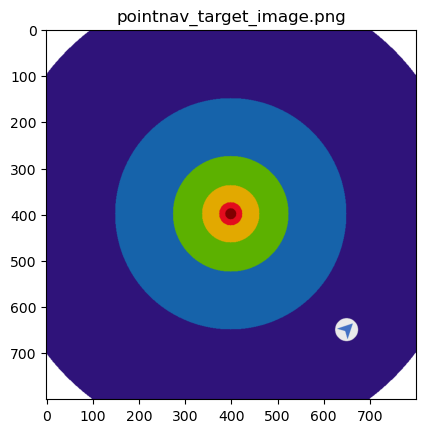

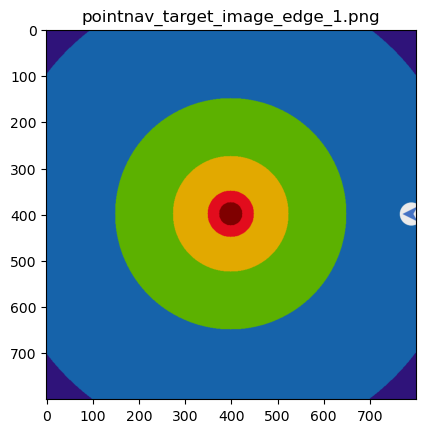

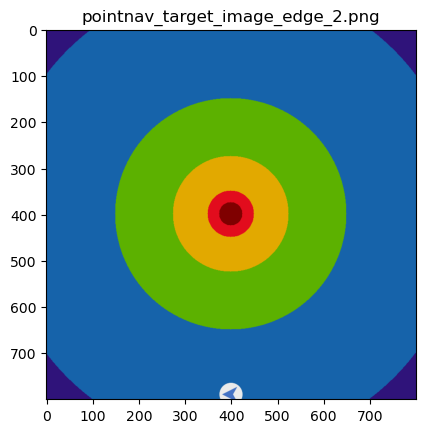

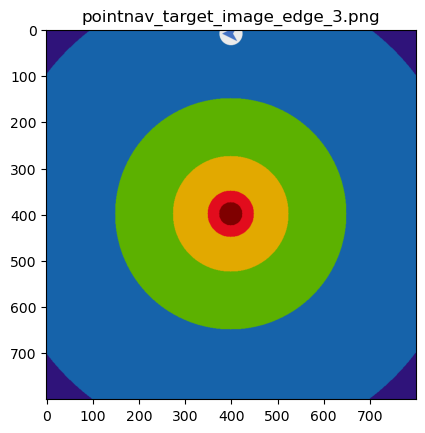

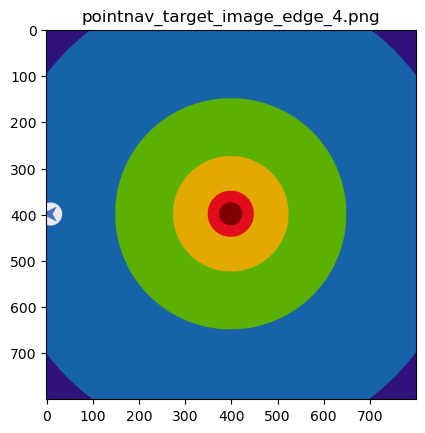

2024-04-14 10:56:28,125 Initializing dataset PointNav-v1
2024-04-14 10:56:28,430 initializing sim Sim-v0
[10:56:28:590878]:[Warning]:[Assets] ResourceManager.cpp(369)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SceneInstanceAttributes-provided name : `data/scene_datasets/habitat-test-scenes/skokloster-castle.scn` nor constructed filename : `data/scene_datasets/habitat-test-scenes/info_semantic.json` exist on disk.
2024-04-14 10:56:29,723 Initializing task Nav-v0
[10:56:29:683930]:[Warning]:[Sim] Simulator.cpp(533)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0


Renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 535.129.03
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


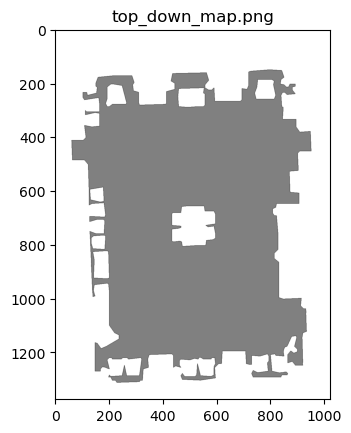

2024-04-14 10:56:31,277 Initializing dataset PointNav-v1
2024-04-14 10:56:31,567 initializing sim Sim-v0
2024-04-14 10:56:32,617 Initializing task Nav-v0
[10:56:31:578927]:[Warning]:[Assets] ResourceManager.cpp(369)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SceneInstanceAttributes-provided name : `data/scene_datasets/habitat-test-scenes/skokloster-castle.scn` nor constructed filename : `data/scene_datasets/habitat-test-scenes/info_semantic.json` exist on disk.
[10:56:32:613615]:[Warning]:[Sim] Simulator.cpp(533)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0


Renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 535.129.03
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


NameError: name 'output_path' is not defined

In [7]:
if __name__ == "__main__":
    example_pointnav_draw_target_birdseye_view()
    example_pointnav_draw_target_birdseye_view_agent_on_border()
    example_get_topdown_map()
    example_top_down_map_measure()